In [376]:
# predict price?
# Can you describe the vibe of each Seattle neighborhood using listing descriptions?
# What are the busiest times of the year to visit Seattle? By how much do prices spike?
# Is there a general upward trend of both new Airbnb listings and total Airbnb visitors to Seattle?

# what kind of listing will get the best rating?
# what kind of listing is the most expensive?

# predict positive / negative comment? sentiment - https://docs.aws.amazon.com/comprehend/latest/dg/how-sentiment.html
# find out the vatiables relationships

In [377]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
#import seaborn as sns
%matplotlib inline

In [378]:
# explore calendar data
df_cal = pd.read_csv('./seattle/calendar.csv')
df_cal.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


In [379]:
# explore listing data
df_listings = pd.read_csv('./seattle/listings.csv')
df_listings.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


In [380]:
# explore reviews data
df_reviews = pd.read_csv('./seattle/reviews.csv')
df_reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,7202016,38917982,2015-07-19,28943674,Bianca,Cute and cozy place. Perfect location to every...
1,7202016,39087409,2015-07-20,32440555,Frank,Kelly has a great room in a very central locat...
2,7202016,39820030,2015-07-26,37722850,Ian,"Very spacious apartment, and in a great neighb..."
3,7202016,40813543,2015-08-02,33671805,George,Close to Seattle Center and all it has to offe...
4,7202016,41986501,2015-08-10,34959538,Ming,Kelly was a great host and very accommodating ...


In [381]:
print('calendar shape:', df_cal.shape)
print('listings shape:', df_listings.shape)
print('reviews shape:', df_reviews.shape)

calendar shape: (1393570, 4)
listings shape: (3818, 92)
reviews shape: (84849, 6)


In [382]:
# transform amenities values to one hot vector

amenities = []

for val in df_listings.amenities:
    try:
        # remove brackets
        val =  val[1:-1]
        # remove quote sign
        val = val.replace("\"", "")
        amenities.extend(val.split(','))
    except AttributeError:
        pass

# convert to set
amenities = set(amenities)

# remove empty string
amenities.remove('')
print(amenities)

{'Indoor Fireplace', 'Smoking Allowed', 'Shampoo', 'Elevator in Building', 'Suitable for Events', 'Other pet(s)', 'Carbon Monoxide Detector', 'Laptop Friendly Workspace', 'Washer / Dryer', 'Heating', 'Breakfast', 'Dog(s)', 'Internet', 'Fire Extinguisher', 'Pets live on this property', 'Pets Allowed', 'Doorman', 'Cat(s)', 'Iron', 'Washer', 'Dryer', 'Free Parking on Premises', 'Smoke Detector', 'Safety Card', 'TV', 'Family/Kid Friendly', 'First Aid Kit', 'Essentials', 'Hair Dryer', 'Cable TV', 'Hot Tub', 'Pool', '24-Hour Check-in', 'Buzzer/Wireless Intercom', 'Gym', 'Kitchen', 'Wireless Internet', 'Air Conditioning', 'Lock on Bedroom Door', 'Wheelchair Accessible', 'Hangers'}


In [383]:
def split_amenities(val,amenity_check):
    try:
        if val.find(amenity_check) >-1:
            return 1
        else:
            return 0
    except AttributeError:
        return 0

# convert values    
for amenity in amenities:        
    df_listings[amenity] = df_listings['amenities'].apply(lambda x: split_amenities(x, amenity))
    
    
# fill in     
    
df_listings.head()    

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,Pool,24-Hour Check-in,Buzzer/Wireless Intercom,Gym,Kitchen,Wireless Internet,Air Conditioning,Lock on Bedroom Door,Wheelchair Accessible,Hangers
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,0,0,0,0,1,1,1,0,0,0
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,0,0,1,0,1,1,0,0,0,0
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,0,0,0,0,1,1,1,0,0,0
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,0,0,0,0,1,1,0,0,0,0
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,0,0,0,0,1,1,0,0,0,0


In [384]:
# check missing data for calendar
np.sum(df_cal.isnull()).sort_values(ascending=False)

price         459028
available          0
date               0
listing_id         0
dtype: int64

In [385]:
# check missing data for listings
#np.sum(df_listings.isnull()).sort_values(ascending=False)

In [386]:
# check missing data for reviews
#np.sum(df_reviews.isnull()).sort_values(ascending=False)

In [387]:
#df_listings.hist()

## What are the busiest times of the year to visit Seattle? By how much do prices spike?

In [388]:
# convert date to datetime
df_cal['date'] = pd.to_datetime(df_cal['date'])

# check the busiest period
df_cal['month'] = df_cal['date'].dt.to_period('M')

In [389]:
df_cal.head()

,listing_id,date,available,price,month
0,241032,2016-01-04,t,$85.00,2016-01
1,241032,2016-01-05,t,$85.00,2016-01
2,241032,2016-01-06,f,NaN,2016-01
3,241032,2016-01-07,f,NaN,2016-01
4,241032,2016-01-08,f,NaN,2016-01


In [390]:
# limit the data to 2016 only as there are few record in 2017
df_cal = df_cal[df_cal['date'] < '2017-01-01']

# convert the price to number
df_cal['price'] = df_cal[df_cal['price'].isnull() == False]['price'].apply(lambda x: float(x[1:].replace(',', '')))

In [391]:
# check number of data in the year for a listing_id
df_cal.groupby(['listing_id']).count()['available'].unique()

# we have only 363 days of data, the first 3 days in Jan-2016 is missing

array([363])

In [392]:
# get the unavailabe count ('f') for each day
df_available_f = df_cal[df_cal['available'] == 'f'].groupby(['month']).count()['listing_id'].reset_index(name="count")
df_available_f.head(12)

,month,count
0,2016-01,47665
1,2016-02,37401
2,2016-03,34420
3,2016-04,38503
4,2016-05,38387
5,2016-06,37296
6,2016-07,44136
7,2016-08,42011
8,2016-09,37294
9,2016-10,35920


In [393]:
# get the availabe count ('t') for each day
# https://stackoverflow.com/questions/29836477/pandas-create-new-column-with-count-from-groupby
df_available_t = df_cal[df_cal['available'] == 't'].groupby(['month']).count()['listing_id'].reset_index(name="count")
df_available_t.head(12)

,month,count
0,2016-01,59239
1,2016-02,73321
2,2016-03,83938
3,2016-04,76037
4,2016-05,79971
5,2016-06,77244
6,2016-07,74222
7,2016-08,76347
8,2016-09,77246
9,2016-10,82438


In [394]:
df_cal['listing_id'].nunique()

3818

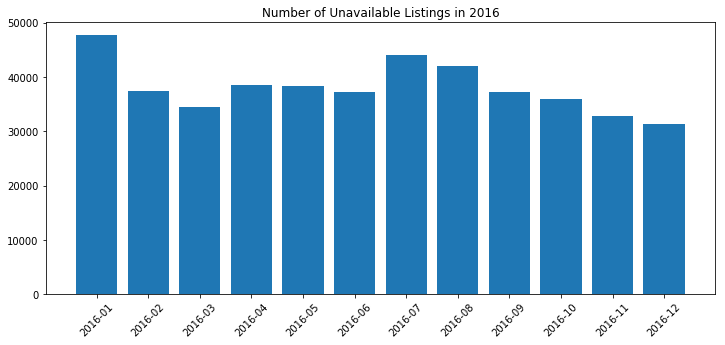

In [395]:
# https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib
# https://stackoverflow.com/questions/44100429/plotting-period-series-in-matplotlib-pyplot
x = np.arange(0,len(df_available_f),1)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x, df_available_f['count'])
ax.set_xticks(x)
ax.set_xticklabels(df_available_f['month'])
plt.xticks(rotation=45)
plt.title('Number of Unavailable Listings in 2016')
plt.show()

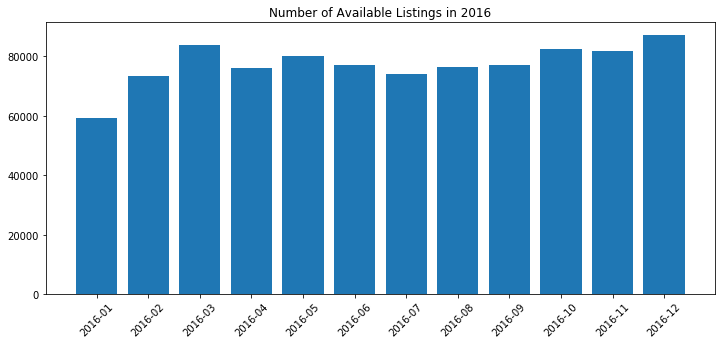

In [396]:
x = np.arange(0,len(df_available_t),1)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.bar(x, df_available_t['count'])
ax.set_xticks(x)
ax.set_xticklabels(df_available_t['month'])
plt.xticks(rotation=45)
plt.title('Number of Available Listings in 2016')
plt.show()

In [397]:
df_available_t['count'] + df_available_f['count']

0     106904
1     110722
2     118358
3     114540
4     118358
5     114540
6     118358
7     118358
8     114540
9     118358
10    114540
11    118358
Name: count, dtype: int64

From the charts above, we can see the busiest period in 2016 is Jan-2016 and Jul-2016

## Now the price. Plot some charts on the price changs during the year

In [398]:
# average price for each day
df_day_price = df_cal[df_cal['available'] == 't'].groupby(['date']).mean()['price'].reset_index(name="avg_price")
df_day_price.head()

,date,avg_price
0,2016-01-04,122.085879
1,2016-01-05,120.681307
2,2016-01-06,120.928258
3,2016-01-07,120.958896
4,2016-01-08,127.640853


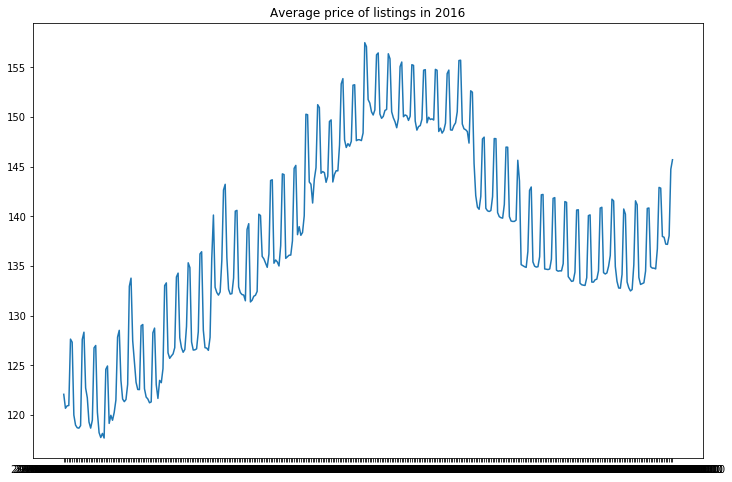

In [399]:
x = np.arange(0,len(df_day_price),1)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.plot(x, df_day_price['avg_price'])
ax.set_xticks(x)
ax.set_xticklabels(df_day_price['date'])
plt.title('Average price of listings in 2016')
plt.show()

In [400]:
# average price by month
df_month_price = df_cal.groupby(['month']).mean()['price'].reset_index(name="avg_price")
df_month_price.head(12)

,month,avg_price
0,2016-01,121.568409
1,2016-02,124.293927
2,2016-03,128.644488
3,2016-04,135.097005
4,2016-05,139.538183
5,2016-06,147.473137
6,2016-07,152.094150
7,2016-08,150.656594
8,2016-09,143.255949
9,2016-10,137.031939


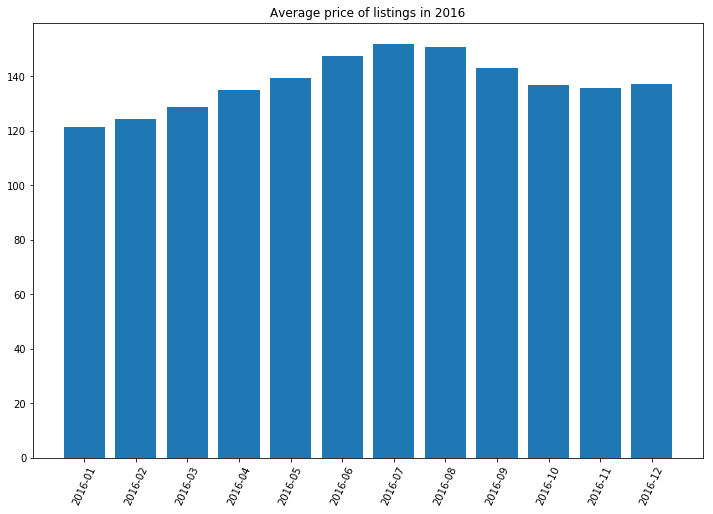

In [401]:
x = np.arange(0,len(df_month_price),1)
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.bar(x, df_month_price['avg_price'])
ax.set_xticks(x)
plt.xticks(rotation=65)
ax.set_xticklabels(df_month_price['month'])
plt.title('Average price of listings in 2016')
plt.show()

# Let's study the price change in Jul-2016

In [402]:
# average price for Jul-2016
#df_july = df_cal.query("available == 't' and date.month == 7")
df_july = df_cal[(df_cal['available'] == 't') & (df_cal['date'].dt.month == 7)]
df_july_price = df_july.groupby(['date']).mean()['price'].reset_index(name="avg_price")
df_july_price.head()

,date,avg_price
0,2016-07-01,157.480000
1,2016-07-02,157.080967
2,2016-07-03,151.752961
3,2016-07-04,151.402362
4,2016-07-05,150.522832


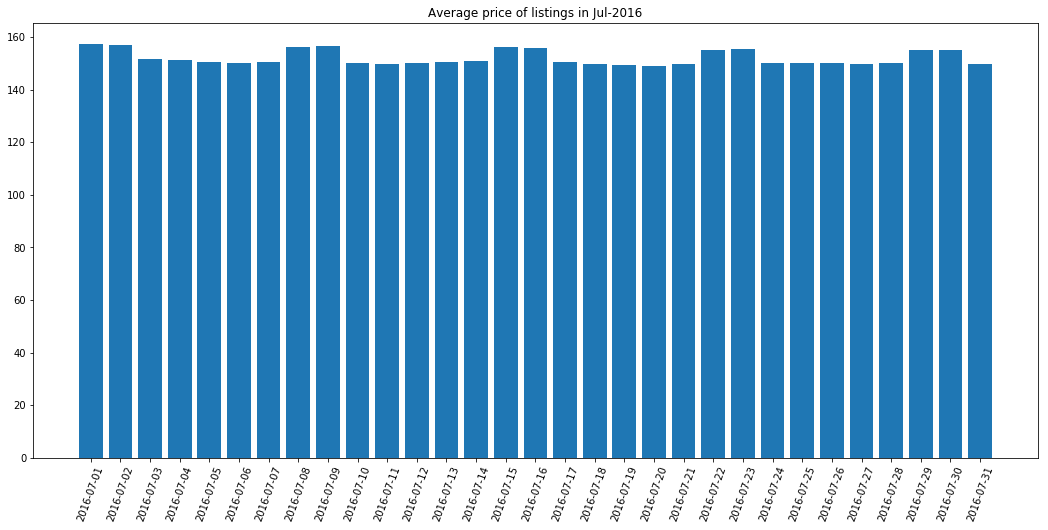

In [403]:
x = np.arange(0,len(df_july_price),1)
fig, ax = plt.subplots(1, 1, figsize=(18, 8))
ax.bar(x, df_july_price['avg_price'])
ax.set_xticks(x)
ax.set_xticklabels(df_july_price['date'].dt.strftime('%Y-%m-%d'))
plt.xticks(rotation=70)
plt.title('Average price of listings in Jul-2016')
plt.show()

We can see the prices for 1-Jul, 2-Jul, 8-Jul, 9-Jul, 15-Jul, 16-Jul, 22-Jul, 23-Jul, 29-Jul and 30-Jul (Friday, Saturday) were higher than the prices on other days

In [404]:
# average price by listings
df_month_price = df_cal.groupby(['listing_id']).mean()['price'].reset_index(name="avg_price").sort_values(by='avg_price', ascending=False)
df_month_price.head()

,listing_id,avg_price
977,3308979,1304.816514
2673,7733192,1011.709497
1541,4825073,1000.000000
823,2720963,950.000000
1409,4464824,910.333333


We can see the average price is the highest in Jul-2016

##  Relationship between Rating and Type

In [405]:
df_listings.sort_values(by=['review_scores_rating', 'number_of_reviews'], ascending=[True, False])
#df_listings.sort_values(by=['number_of_reviews'], ascending=[False])

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,Pool,24-Hour Check-in,Buzzer/Wireless Intercom,Gym,Kitchen,Wireless Internet,Air Conditioning,Lock on Bedroom Door,Wheelchair Accessible,Hangers
1222,9183838,https://www.airbnb.com/rooms/9183838,20160104002432,2016-01-04,Belltown / Downtown Apartment,This 700 square foot apartment is close to res...,"The Space This is a 700 square foot, one bedro...",This 700 square foot apartment is close to res...,none,NaN,...,0,0,0,0,1,1,0,0,0,0
1666,9151374,https://www.airbnb.com/rooms/9151374,20160104002432,2016-01-04,Capital Hill Living,Coppins Well is a conveniently located beauti...,NaN,Coppins Well is a conveniently located beauti...,none,NaN,...,0,0,0,1,1,1,0,0,1,0
3148,5639238,https://www.airbnb.com/rooms/5639238,20160104002432,2016-01-04,1 BR Apt Steps to Space Needle,Mid-sized one bedroom apartment situated just ...,Very close to Seattle Center and Key Arena. C...,Mid-sized one bedroom apartment situated just ...,none,NaN,...,0,0,1,1,1,1,0,0,0,0
1162,9151865,https://www.airbnb.com/rooms/9151865,20160104002432,2016-01-04,94 walking score BDRM in SLU,Bedroom+private bathroom ready for daily or mo...,NaN,Bedroom+private bathroom ready for daily or mo...,none,NaN,...,0,0,1,1,1,1,0,0,0,1
2320,8474294,https://www.airbnb.com/rooms/8474294,20160104002432,2016-01-04,Cozy 2Br/2Bt Apt close to park,"Our cozy two bedroom/ two bathroom apartment, ...",Please feel free to look at our other listings...,"Our cozy two bedroom/ two bathroom apartment, ...",none,The Neighborhood Start the day off right with ...,...,0,0,0,0,1,1,0,0,0,0
2474,4892529,https://www.airbnb.com/rooms/4892529,20160104002432,2016-01-04,Daylight basement,"1650 sq ft. Very clean, bright and spacious A...","Beautiful Ravenna area. Quiet, safe and charmi...","1650 sq ft. Very clean, bright and spacious A...",none,"Beautiful Ravenna area. Quiet, safe and charmi...",...,0,0,0,0,1,1,0,0,1,0
1219,6370313,https://www.airbnb.com/rooms/6370313,20160104002432,2016-01-04,Luxury Furnished 1BR Seattle Apt,Inside this apartment guests will find a fully...,NaN,Inside this apartment guests will find a fully...,none,NaN,...,1,0,0,1,1,1,1,0,0,0
1972,9075558,https://www.airbnb.com/rooms/9075558,20160104002432,2016-01-04,Private Bedroom in a Modern House,My brand new townhouse on the third row from s...,NaN,My brand new townhouse on the third row from s...,none,"15-20 minutes to the downtown by E-line, while...",...,0,1,0,0,0,1,0,0,0,0
2776,8934054,https://www.airbnb.com/rooms/8934054,20160104002432,2016-01-04,Condo rental room in downtown!,"Room with a Queen Bed, mini fridge, ironing bo...","2 bedroom secured artsy/lux condo, in the hear...","Room with a Queen Bed, mini fridge, ironing bo...",none,Our neighborhood is the most colorful of all w...,...,0,0,0,0,1,1,1,0,0,1
2723,4082250,https://www.airbnb.com/rooms/4082250,20160104002432,2016-01-04,Apartment in heart of Capitol Hill,This charming 1 Bed / 1 Bath apartment in the ...,The apartment is located on the 1st of 3 level...,This charming 1 Bed / 1 Bath apartment in the ...,none,The apartment is just a block and half from Pi...,...,0,0,0,0,1,1,0,0,0,0


In [406]:
df_listings[df_listings['id'] == 8474294]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,Pool,24-Hour Check-in,Buzzer/Wireless Intercom,Gym,Kitchen,Wireless Internet,Air Conditioning,Lock on Bedroom Door,Wheelchair Accessible,Hangers
2320,8474294,https://www.airbnb.com/rooms/8474294,20160104002432,2016-01-04,Cozy 2Br/2Bt Apt close to park,"Our cozy two bedroom/ two bathroom apartment, ...",Please feel free to look at our other listings...,"Our cozy two bedroom/ two bathroom apartment, ...",none,The Neighborhood Start the day off right with ...,...,0,0,0,0,1,1,0,0,0,0


In [407]:
df_listings.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'Pool', '24-Hour Check-in', 'Buzzer/Wireless Intercom', 'Gym',
       'Kitchen', 'Wireless Internet', 'Air Conditioning',
       'Lock on Bedroom Door', 'Wheelchair Accessible', 'Hangers'],
      dtype='object', length=133)

In [408]:
df_listings.groupby(['property_type', 'room_type','bed_type']).mean()[['review_scores_rating', 'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

review_scores_rating  \
property_type   room_type       bed_type                              
Apartment       Entire home/apt Airbed                          NaN   
                                Couch                           NaN   
                                Futon                     95.562500   
                                Pull-out Sofa             92.888889   
                                Real Bed                  93.971014   
                Private room    Airbed                    88.666667   
                                Futon                     92.400000   
                                Pull-out Sofa             91.250000   
                                Real Bed                  93.850575   
                Shared room     Airbed                    95.333333   
                                Couch                     97.200000   
                                Futon                     91.100000   
                                Pull-out Sofa             97.800000   
                                Real Bed                  96.875000   
Bed & Breakfast Entire home/apt Real Bed                  95.500000   
                Private room    Real Bed                  95.695652   
                Shared room     Couch                     97.000000   
Boat            Entire home/apt Real Bed                  96.000000   
                Private room    Couch                           NaN   
                                Real Bed                  95.000000   
Bungalow        Entire home/apt Real Bed                  98.125000   
                Private room    Real Bed                  94.000000   
Cabin           Entire home/apt Futon                     98.500000   
                                Real Bed                  97.214286   
                Private room    Real Bed                  92.600000   
Camper/RV       Entire home/apt Pull-out Sofa             95.000000   
                                Real Bed                  96.666667   
                Private room    Real Bed                  94.000000   
                Shared room     Real Bed                        NaN   
Chalet          Entire home/apt Real Bed                  96.000000   
...                                                             ...   
House           Entire home/apt Real Bed                  94.914780   
                Private room    Airbed                    94.625000   
                                Futon                     94.526316   
                                Pull-out Sofa             95.500000   
                                Real Bed                  94.961165   
                Shared room     Couch                    100.000000   
                                Real Bed                  91.209302   
Loft            Entire home/apt Pull-out Sofa             98.000000   
                                Real Bed                  96.040000   
                Private room    Pull-out Sofa             93.000000   
                                Real Bed                  93.000000   
                Shared room     Real Bed                        NaN   
Other           Entire home/apt Real Bed                  97.818182   
                Private room    Futon                     99.000000   
                                Pull-out Sofa                   NaN   
                                Real Bed                  93.400000   
                Shared room     Real Bed                  93.500000   
Tent            Entire home/apt Airbed                    94.000000   
                                Real Bed                 100.000000   
                Private room    Airbed                          NaN   
                Shared room     Real Bed                  90.000000   
Townhouse       Entire home/apt Real Bed                  96.342857   
                Private room    Futon                    100.000000   
                                Pull-out Sofa             97.000000   


(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

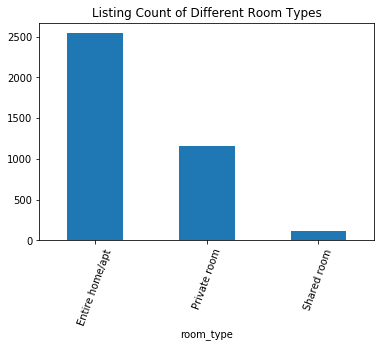

In [580]:
#df_listings.groupby(['room_type']).count()[['review_scores_rating']].plot(kind="bar", legend=False)
df_listings.groupby(['room_type']).count()[['id']].plot(kind="bar", legend=False)
plt.title("Listing Count of Different Room Types")
plt.xticks(rotation=70)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

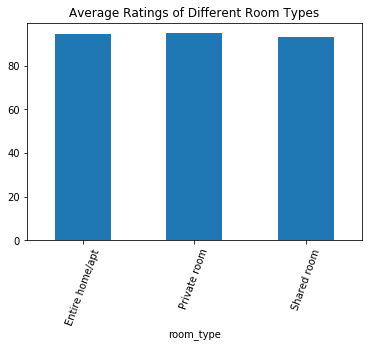

In [579]:
df_listings.groupby(['room_type']).mean()[['review_scores_rating']].plot(kind="bar", legend=False)
plt.title("Average Ratings of Different Room Types")
plt.xticks(rotation=70)

In [590]:
df_listings.groupby(['neighbourhood']).mean()[['review_scores_rating']].sort_values('review_scores_rating')
#.plot(kind="bar", legend=False)
#plt.title("Average Ratings of Different Room Types")
#plt.xticks(rotation=70)

,review_scores_rating
neighbourhood,
Pinehurst,85.666667
University District,87.619048
South Park,88.000000
View Ridge,88.200000
South Beacon Hill,89.500000
Roxhill,90.000000
Interbay,90.333333
Olympic Hills,90.700000
Ravenna,91.125000


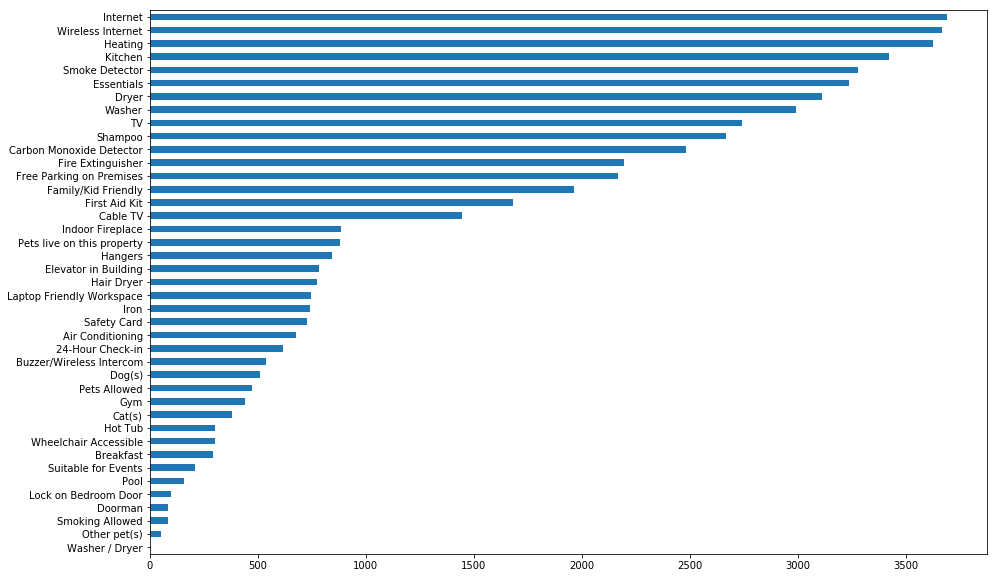

In [410]:
df_listings.sum()[list(amenities)].sort_values(ascending=True).plot(kind ='barh', figsize=(15, 10))

In [423]:
amenities_list = list(amenities)
with_amenity_avg_rating = []
without_amenity_avg_rating = []
for en in amenities_list:
    with_amenity_avg_rating.append(df_listings[df_listings[en] == 1].mean()['review_scores_rating'])
    without_amenity_avg_rating.append(df_listings[df_listings[en] == 0].mean()['review_scores_rating'])
        
df_amenities_rating = pd.DataFrame()
df_amenities_rating['amenity'] = amenities_list
df_amenities_rating['with_avg'] = with_amenity_avg_rating
df_amenities_rating['without_avg'] = without_amenity_avg_rating

df_amenities_rating.head()

,amenity,with_avg,without_avg
0,Indoor Fireplace,95.211669,94.335661
1,Smoking Allowed,95.205882,94.524654
2,Shampoo,95.081034,93.146396
3,Elevator in Building,94.330247,94.592945
4,Suitable for Events,93.731183,94.589615


In [464]:
# reset index
# https://www.dataquest.io/blog/adding-axis-labels-to-plots-with-pandas-and-matplotlib/
df_amenities_rating.set_index("amenity", drop=True, inplace=True)

,with_avg,without_avg
amenity,,
Indoor Fireplace,95.211669,94.335661
Smoking Allowed,95.205882,94.524654
Shampoo,95.081034,93.146396
Elevator in Building,94.330247,94.592945
Suitable for Events,93.731183,94.589615
Other pet(s),95.162791,94.530691
Carbon Monoxide Detector,95.015144,93.588847
Laptop Friendly Workspace,95.588991,94.321401
Washer / Dryer,81.000000,94.543533


In [494]:
df_amenities_rating = df_amenities_rating.sort_values("with_avg", ascending=False)
df_amenities_rating

,with_avg,without_avg
amenity,,
Doorman,96.411765,94.498228
Safety Card,95.951768,94.194586
Cat(s),95.843558,94.389807
Pets live on this property,95.634794,94.198098
Laptop Friendly Workspace,95.588991,94.321401
Air Conditioning,95.462633,94.340360
Dog(s),95.454545,94.396061
Breakfast,95.413655,94.464750
First Aid Kit,95.366921,93.851617


In [584]:
df_amenities_rating[abs(df_amenities_rating['with_avg'] - df_amenities_rating['without_avg']) > 2]

,with_avg,without_avg
amenity,,
Internet,94.621971,91.171053
Wireless Internet,94.620779,91.780220
Washer / Dryer,81.000000,94.543533


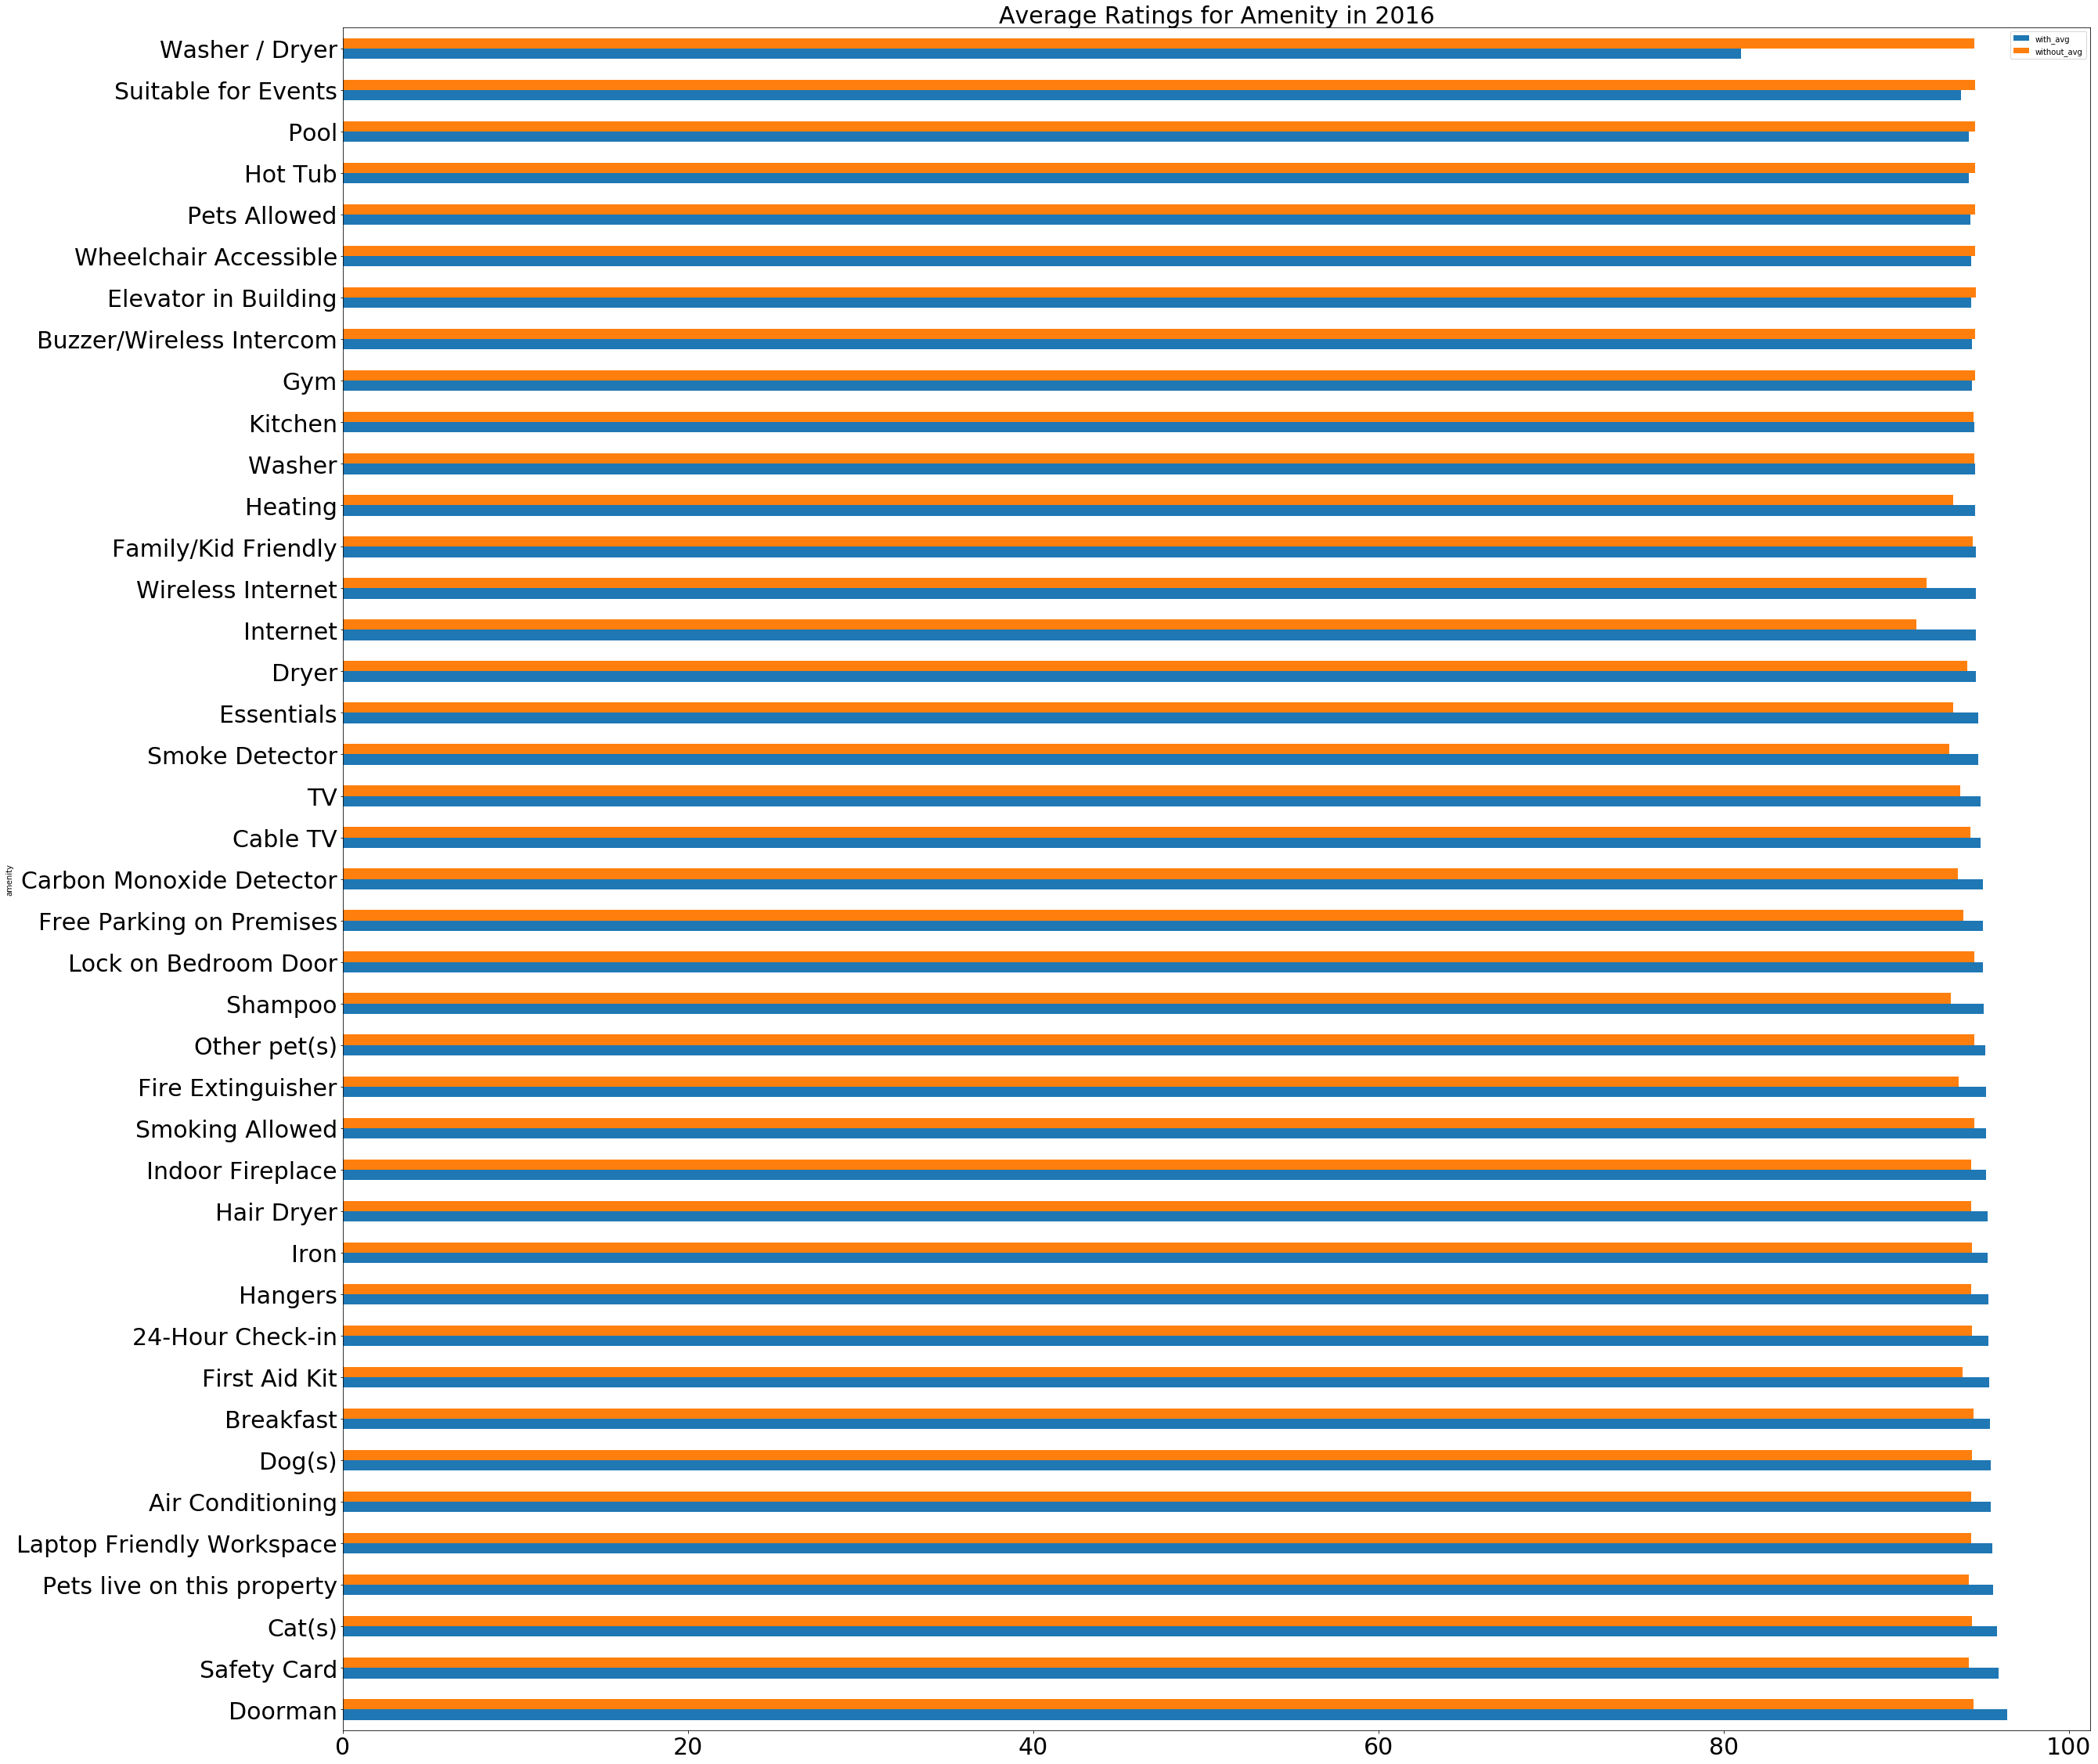

In [507]:
df_amenities_rating.plot(kind="barh", figsize=(40, 40), use_index=True, fontsize=30)
plt.title("Average Ratings for Amenity in 2016", fontsize=30)
plt.show()

# Trend of Listing Count

Text(0.5,1,'No of Host Since')

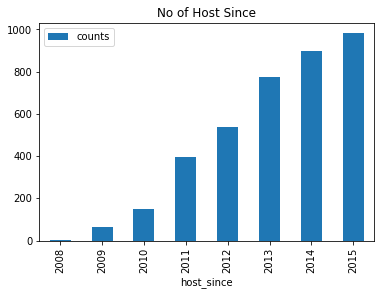

In [576]:
df_host_since = pd.to_datetime(df_listings['host_since']).dt.to_period('A').value_counts().rename_axis('host_since').reset_index(name='counts')
df_host_since = df_host_since[df_host_since['host_since'] < pd.to_datetime('2016-01-01').to_period('A')]
df_host_since = df_host_since.sort_values(by='host_since')
df_host_since.set_index("host_since", drop=True, inplace=True)
df_host_since.plot(kind='bar')
plt.title("No of Host Since")

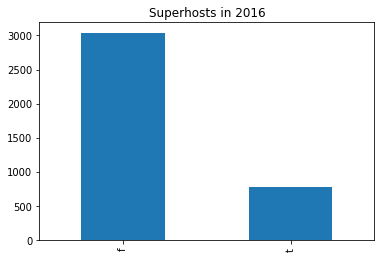

In [414]:
df_superhosts_count = df_listings['host_is_superhost'].value_counts()
df_superhosts_count.plot(kind ='bar')
plt.title("Superhosts in 2016")
plt.show()